# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
lloc = True # localization switch (True=Apply, False=Not apply)
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
#analysis = Mlef(pt, obs, 1.1, model)
analysis = Mlef(pt, obs, 1.1)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, 1.1, 4.0, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, 1.1, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2021-01-08 09:57:43,826 anl INFO model : model
2021-01-08 09:57:43,827 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1


In [6]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

In [8]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
dof = np.zeros(na) # DOF for signal
for i in a_time:
    # read observation
    y = yobs[i:i+a_window]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, chi2, ds = analysis(u, pf, y, \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)
    else: # assimilate observations at a time
        u, pa, chi2, ds = analysis(u, pf, y[0], \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)

    xa[i] = u # analysis
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    dof[i] = ds
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft == "deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    

2021-01-08 09:58:51,679 anl INFO save_dh=False
2021-01-08 09:58:51,687 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2021-01-08 09:58:51,688 anl INFO save_hist=False
2021-01-08 09:58:51,803 anl INFO success=False message=Desired error not necessarily achieved due to precision loss.
2021-01-08 09:58:51,804 anl INFO J=1.237e+02 dJ=5.973e-05 nit=102
2021-01-08 09:58:51,810 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2021-01-08 09:58:51,811 anl INFO dof=19.913822774233424
2021-01-08 09:58:51,812 anl INFO ==inflat

2021-01-08 09:58:52,150 anl INFO save_dh=False
2021-01-08 09:58:52,159 anl INFO singular value =[0.92124087 0.87917485 0.86507927 0.82177344 0.78804453 0.63842966
 0.62361719 0.60643331 0.57573478 0.56285502 0.52623236 0.47704141
 0.44491916 0.43669849 0.42191369 0.39905883 0.36615674 0.34651794
 0.27920188 0.2614249 ]
2021-01-08 09:58:52,161 anl INFO save_hist=False
2021-01-08 09:58:52,168 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:52,169 anl INFO J=1.230e+02 dJ=1.987e-06 nit=7
2021-01-08 09:58:52,179 anl INFO singular value =[0.92124087 0.87917485 0.86507927 0.82177344 0.78804453 0.63842966
 0.62361719 0.60643331 0.57573478 0.56285502 0.52623236 0.47704141
 0.44491916 0.43669849 0.42191369 0.39905883 0.36615674 0.34651794
 0.27920188 0.2614249 ]
2021-01-08 09:58:52,181 anl INFO dof=4.815110687769302
2021-01-08 09:58:52,182 anl INFO ==inflation==
2021-01-08 09:58:52,187 anl INFO save_dh=False
2021-01-08 09:58:52,196 anl INFO singular value =[0

2021-01-08 09:58:52,432 anl INFO save_hist=False
2021-01-08 09:58:52,437 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:52,437 anl INFO J=7.232e+01 dJ=1.005e-06 nit=8
2021-01-08 09:58:52,445 anl INFO singular value =[1.05269575 0.89357297 0.85293687 0.83810973 0.75129949 0.69069469
 0.67705549 0.60495842 0.57769973 0.49828052 0.41837525 0.40172318
 0.38561104 0.33292678 0.32916418 0.27073485 0.24528458 0.21964252
 0.18709385 0.17575344]
2021-01-08 09:58:52,446 anl INFO dof=4.368258975781885
2021-01-08 09:58:52,447 anl INFO ==inflation==
2021-01-08 09:58:52,453 anl INFO save_dh=False
2021-01-08 09:58:52,460 anl INFO singular value =[1.02826313 0.91153824 0.85250954 0.81186234 0.73040669 0.68094991
 0.6382011  0.61138335 0.58306797 0.49713365 0.43201927 0.40136324
 0.37069852 0.35141942 0.31051477 0.28524936 0.2501581  0.21510134
 0.18802172 0.1677697 ]
2021-01-08 09:58:52,461 anl INFO save_hist=False
2021-01-08 09:58:52,466 anl INFO success=True mes

2021-01-08 09:58:52,710 anl INFO J=4.737e+01 dJ=4.806e-07 nit=7
2021-01-08 09:58:52,716 anl INFO singular value =[0.81777314 0.78967715 0.75584855 0.68733786 0.6255751  0.58024808
 0.56132    0.54101711 0.52160801 0.51015098 0.44528459 0.40682095
 0.38791806 0.38307607 0.30364541 0.28971639 0.26206945 0.23608154
 0.22529831 0.17912753]
2021-01-08 09:58:52,718 anl INFO dof=3.8133755056167193
2021-01-08 09:58:52,718 anl INFO ==inflation==
2021-01-08 09:58:52,724 anl INFO save_dh=False
2021-01-08 09:58:52,732 anl INFO singular value =[0.84308317 0.83659005 0.75565921 0.66095662 0.61475869 0.5799236
 0.56835946 0.53710655 0.51487603 0.49273191 0.46271178 0.43688138
 0.40569871 0.3934711  0.33083737 0.31507673 0.25471825 0.22791892
 0.21669941 0.17030534]
2021-01-08 09:58:52,733 anl INFO save_hist=False
2021-01-08 09:58:52,738 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:52,739 anl INFO J=4.333e+01 dJ=3.149e-07 nit=7
2021-01-08 09:58:52,746 anl INFO s

2021-01-08 09:58:52,984 anl INFO dof=4.12861291214223
2021-01-08 09:58:52,984 anl INFO ==inflation==
2021-01-08 09:58:52,989 anl INFO save_dh=False
2021-01-08 09:58:52,996 anl INFO singular value =[1.05967811 0.8429325  0.78651255 0.77292132 0.74630276 0.60841966
 0.58378395 0.56634054 0.52236905 0.50855215 0.45916232 0.42029231
 0.39117637 0.38520904 0.32476238 0.23915595 0.22039647 0.1893791
 0.17365901 0.15125272]
2021-01-08 09:58:52,997 anl INFO save_hist=False
2021-01-08 09:58:53,002 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:53,002 anl INFO J=3.294e+01 dJ=1.448e-06 nit=7
2021-01-08 09:58:53,011 anl INFO singular value =[1.05967811 0.8429325  0.78651255 0.77292132 0.74630276 0.60841966
 0.58378395 0.56634054 0.52236905 0.50855215 0.45916232 0.42029231
 0.39117637 0.38520904 0.32476238 0.23915595 0.22039647 0.1893791
 0.17365901 0.15125272]
2021-01-08 09:58:53,012 anl INFO dof=4.113549820991222
2021-01-08 09:58:53,013 anl INFO ==inflation==

2021-01-08 09:58:53,255 anl INFO save_dh=False
2021-01-08 09:58:53,263 anl INFO singular value =[1.03645316 0.89339351 0.75539668 0.74193295 0.7111383  0.66238502
 0.65017585 0.55754477 0.55324116 0.52707227 0.46126375 0.41673954
 0.41294791 0.35926361 0.30694407 0.27534268 0.23160748 0.19519973
 0.1570889  0.0965995 ]
2021-01-08 09:58:53,264 anl INFO save_hist=False
2021-01-08 09:58:53,269 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:53,269 anl INFO J=2.754e+01 dJ=1.941e-06 nit=7
2021-01-08 09:58:53,277 anl INFO singular value =[1.03645316 0.89339351 0.75539668 0.74193295 0.7111383  0.66238502
 0.65017585 0.55754477 0.55324116 0.52707227 0.46126375 0.41673954
 0.41294791 0.35926361 0.30694407 0.27534268 0.23160748 0.19519973
 0.1570889  0.0965995 ]
2021-01-08 09:58:53,279 anl INFO dof=4.167876331971426
2021-01-08 09:58:53,279 anl INFO ==inflation==
2021-01-08 09:58:53,284 anl INFO save_dh=False
2021-01-08 09:58:53,292 anl INFO singular value =[1

2021-01-08 09:58:53,524 anl INFO save_hist=False
2021-01-08 09:58:53,529 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:53,530 anl INFO J=1.593e+01 dJ=4.481e-07 nit=7
2021-01-08 09:58:53,538 anl INFO singular value =[0.88405681 0.79719596 0.72181773 0.71331036 0.6897419  0.62928902
 0.60075195 0.57230142 0.51467378 0.47867503 0.46638795 0.42303064
 0.39269665 0.34887742 0.31314716 0.2877895  0.27256353 0.25031355
 0.2008674  0.19474673]
2021-01-08 09:58:53,539 anl INFO dof=3.9626282695319603
2021-01-08 09:58:53,540 anl INFO ==inflation==
2021-01-08 09:58:53,544 anl INFO save_dh=False
2021-01-08 09:58:53,552 anl INFO singular value =[0.88207443 0.75853492 0.71845076 0.71414644 0.68230852 0.65688624
 0.60364119 0.5332507  0.51144367 0.48933883 0.47719929 0.45726629
 0.40814755 0.3649213  0.31935769 0.29437282 0.26694537 0.25037566
 0.19215982 0.17820235]
2021-01-08 09:58:53,553 anl INFO save_hist=False
2021-01-08 09:58:53,558 anl INFO success=True me

2021-01-08 09:58:53,797 anl INFO J=1.719e+01 dJ=9.928e-07 nit=7
2021-01-08 09:58:53,805 anl INFO singular value =[0.93773632 0.86469874 0.67801073 0.63451665 0.62534893 0.60575696
 0.59670829 0.55973805 0.53566132 0.52222026 0.44317921 0.42860191
 0.38544393 0.32940381 0.32577076 0.26916898 0.25293868 0.24549453
 0.18989042 0.13094198]
2021-01-08 09:58:53,806 anl INFO dof=3.8643522841228237
2021-01-08 09:58:53,807 anl INFO ==inflation==
2021-01-08 09:58:53,813 anl INFO save_dh=False
2021-01-08 09:58:53,820 anl INFO singular value =[0.96634722 0.81636951 0.70044202 0.6713737  0.65398192 0.61423213
 0.54916941 0.52332278 0.51363866 0.48439218 0.45725696 0.4327119
 0.3796374  0.34149196 0.3037171  0.26491005 0.24866456 0.23048329
 0.18459731 0.15116967]
2021-01-08 09:58:53,821 anl INFO save_hist=False
2021-01-08 09:58:53,827 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:53,827 anl INFO J=2.611e+01 dJ=1.127e-06 nit=7
2021-01-08 09:58:53,835 anl INFO s

2021-01-08 09:58:54,074 anl INFO dof=3.907652111509681
2021-01-08 09:58:54,075 anl INFO ==inflation==
2021-01-08 09:58:54,080 anl INFO save_dh=False
2021-01-08 09:58:54,088 anl INFO singular value =[0.79924428 0.77080272 0.7614076  0.7345341  0.67009606 0.61165705
 0.56680839 0.55558742 0.51108845 0.50087711 0.46719717 0.42024346
 0.40783033 0.34324342 0.28024465 0.27655182 0.23935516 0.22870159
 0.19540383 0.17210736]
2021-01-08 09:58:54,089 anl INFO save_hist=False
2021-01-08 09:58:54,094 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:54,095 anl INFO J=2.048e+01 dJ=1.121e-06 nit=6
2021-01-08 09:58:54,102 anl INFO singular value =[0.79924428 0.77080272 0.7614076  0.7345341  0.67009606 0.61165705
 0.56680839 0.55558742 0.51108845 0.50087711 0.46719717 0.42024346
 0.40783033 0.34324342 0.28024465 0.27655182 0.23935516 0.22870159
 0.19540383 0.17210736]
2021-01-08 09:58:54,104 anl INFO dof=3.839349845313479
2021-01-08 09:58:54,106 anl INFO ==inflatio

2021-01-08 09:58:54,339 anl INFO save_dh=False
2021-01-08 09:58:54,346 anl INFO singular value =[0.82482484 0.80803998 0.74253108 0.68535462 0.66639819 0.60640208
 0.5369041  0.51137915 0.4859866  0.4587511  0.42055857 0.41695052
 0.356082   0.35091227 0.3112668  0.28168781 0.21327024 0.20848923
 0.1768007  0.15844733]
2021-01-08 09:58:54,347 anl INFO save_hist=False
2021-01-08 09:58:54,352 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:54,352 anl INFO J=2.367e+01 dJ=1.514e-06 nit=6
2021-01-08 09:58:54,360 anl INFO singular value =[0.82482484 0.80803998 0.74253108 0.68535462 0.66639819 0.60640208
 0.5369041  0.51137915 0.4859866  0.4587511  0.42055857 0.41695052
 0.356082   0.35091227 0.3112668  0.28168781 0.21327024 0.20848923
 0.1768007  0.15844733]
2021-01-08 09:58:54,362 anl INFO dof=3.669612352380048
2021-01-08 09:58:54,362 anl INFO ==inflation==
2021-01-08 09:58:54,366 anl INFO save_dh=False
2021-01-08 09:58:54,374 anl INFO singular value =[0

2021-01-08 09:58:54,607 anl INFO save_hist=False
2021-01-08 09:58:54,612 anl INFO success=True message=Optimization terminated successfully.
2021-01-08 09:58:54,612 anl INFO J=2.085e+01 dJ=5.418e-07 nit=7
2021-01-08 09:58:54,620 anl INFO singular value =[0.83489528 0.77081    0.75108073 0.7279456  0.68876648 0.64589536
 0.61106058 0.5173645  0.50457771 0.44121343 0.41509142 0.38193026
 0.34999631 0.33323977 0.31508973 0.27809191 0.25847551 0.22948183
 0.21340822 0.16824269]
2021-01-08 09:58:54,621 anl INFO dof=3.7847083747103856
2021-01-08 09:58:54,621 anl INFO ==inflation==
2021-01-08 09:58:54,626 anl INFO save_dh=False
2021-01-08 09:58:54,634 anl INFO singular value =[0.82172128 0.80712161 0.79412978 0.77393349 0.69613356 0.68454215
 0.58144011 0.48571688 0.46333303 0.4287651  0.41714255 0.36763227
 0.34272626 0.32541416 0.3065276  0.27466926 0.25810577 0.23898171
 0.21957802 0.16418058]
2021-01-08 09:58:54,635 anl INFO save_hist=False
2021-01-08 09:58:54,640 anl INFO success=True me

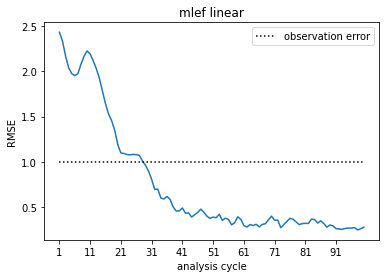

In [9]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()